In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
from keras.models import Model
import keras
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
import cv2

Unzipping the data from the contents of drive, and move 0-9

In [ ]:
!unzip /content/drive/MyDrive/midas/part2.zip

Archive:  /content/drive/MyDrive/midas/part2.zip
   creating: part2/
   creating: part2/0/
  inflating: part2/0/img001-054.png  
  inflating: part2/0/img001-045.png  
  inflating: part2/0/img001-043.png  
  inflating: part2/0/img001-002.png  
  inflating: part2/0/img001-034.png  
  inflating: part2/0/img001-037.png  
  inflating: part2/0/img001-012.png  
  inflating: part2/0/img001-019.png  
  inflating: part2/0/img001-047.png  
  inflating: part2/0/img001-003.png  
  inflating: part2/0/img001-027.png  
  inflating: part2/0/img001-004.png  
  inflating: part2/0/img001-007.png  
  inflating: part2/0/img001-008.png  
  inflating: part2/0/img001-033.png  
  inflating: part2/0/img001-016.png  
  inflating: part2/0/img001-053.png  
  inflating: part2/0/img001-014.png  
  inflating: part2/0/img001-011.png  
  inflating: part2/0/img001-013.png  
  inflating: part2/0/img001-001.png  
  inflating: part2/0/img001-051.png  
  inflating: part2/0/img001-010.png  
  inflating: part2/0/img001-025.png

Using keras' image data generator for augmentation and data flow.

In [ ]:
directory = '/content/part2'

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        validation_split=0.2# randomly shift images vertically (fraction of total height)
        )

# Limit the size of the image to 100x100 pixels
tds = datagen.flow_from_directory(
    directory=directory,
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset="training",
    interpolation="nearest"
)

testds = datagen.flow_from_directory(
    directory=directory,
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset="validation",
    interpolation="nearest",
)

Found 960 images belonging to 10 classes.
Found 240 images belonging to 10 classes.


Custom network with the same architecture as the previous model but alterations made to the leakyreLu layers with alpha = 0.1

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (100, 100, 1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.3))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))  

Models can be found [here](https://drive.google.com/drive/folders/1--gBKwkvqme_n6GlxgKfw_AGOXLuWXPK?usp=sharing)

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/midas/model_check/training0_9/new_new_50.hdf5",
                                                 save_best_only=True,
                                                 verbose=1)
history = model.fit(tds, epochs = 25, validation_data = testds, batch_size = 32,
                    verbose = 1, callbacks=cp_callback)


Epoch 1/25
30/30 [==============================] - 7s 185ms/step - loss: 1.7903 - accuracy: 0.3457 - val_loss: 1.6503 - val_accuracy: 0.4583

Epoch 00001: val_loss improved from inf to 1.65032, saving model to /content/drive/MyDrive/midas/model_check/training0_9/new_new_50.hdf5
Epoch 2/25
30/30 [==============================] - 5s 169ms/step - loss: 1.6393 - accuracy: 0.3855 - val_loss: 1.5297 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.65032 to 1.52972, saving model to /content/drive/MyDrive/midas/model_check/training0_9/new_new_50.hdf5
Epoch 3/25
30/30 [==============================] - 5s 169ms/step - loss: 1.5515 - accuracy: 0.4475 - val_loss: 1.5139 - val_accuracy: 0.4750

Epoch 00003: val_loss improved from 1.52972 to 1.51393, saving model to /content/drive/MyDrive/midas/model_check/training0_9/new_new_50.hdf5
Epoch 4/25
30/30 [==============================] - 5s 169ms/step - loss: 1.5677 - accuracy: 0.4402 - val_loss: 1.5086 - val_accuracy: 0.4708

Epoch 000

### Below I have experimented with editing extraction from the model I have just trained. I removed the last few layers and created another model for training with the MNIST data but this seemed to be inadequate as the above model performed better over the one mentioned below

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 50, 50, 64)      

Removing the last 8 layers and adding a custom head for mnist training

In [ ]:
flat1 = Flatten()(model.layers[-9].output)
class1 = Dense(128)(flat1)
activ1 = LeakyReLU(alpha=0.3)(class1)
dp1 = Dropout(0.2)(activ1)
class2 = Dense(32)(dp1)
dp2 = Dropout(0.2)(class2)
activ2= LeakyReLU(alpha=0.3)(dp2)
output = Dense(10, activation='softmax')(activ2)
mnist_model = Model(inputs=model.inputs, outputs=output)
# (model.layers[-9].output)

In [ ]:
mnist_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135_input (InputLayer [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 50, 50, 64)        18496 

### Using the pretrained model as a feature extractor first

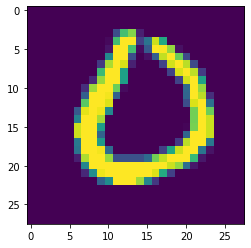

In [ ]:
plt.imshow(x_train[2500])

Reshaping the mnist data to 100x100 as I had trained on it

In [ ]:
def extract_features(image_data=None):
  data = []
  for i in image_data:
    x = cv2.resize(i, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    x = np.expand_dims(x, axis=2)
    x = np.array(x, dtype='float64')
    data.append(x)
  return np.asarray(data)
    

In [ ]:
resized_x_train = extract_features(image_data=x_train)
resized_x_test = extract_features(image_data=x_test)

In [ ]:
y_labels = model.predict(resized_x_test)

In [ ]:
y_pred = np.argmax(y_labels, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.05      0.08       980
           1       0.35      0.02      0.04      1135
           2       0.04      0.04      0.04      1032
           3       0.05      0.10      0.07      1010
           4       0.42      0.03      0.06       982
           5       0.20      0.87      0.33       892
           6       0.38      0.02      0.04       958
           7       0.37      0.63      0.46      1028
           8       0.26      0.07      0.11       974
           9       0.10      0.09      0.10      1009

    accuracy                           0.18     10000
   macro avg       0.24      0.19      0.13     10000
weighted avg       0.24      0.18      0.13     10000



In [ ]:
# training the new mnist model

In [ ]:
resized_y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
resized_y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# new validation data for testing the model
X_train, X_val, y_train, y_val = train_test_split(resized_x_train, resized_y_train, test_size=0.25, random_state=43)

In [ ]:
model.fit(X_train, resized_y_train, validation_data=(resized_x_train, resized_y_test), verbose = 1, batch_size=8, callbacks=None)